# Part 4 - New data on Weekly Claims

- toc: True
- badges: true
- comments: true
- categories: [jupyter]

I was scanning a WSJ article today on jobless claims, 
https://www.wsj.com/articles/weekly-jobless-claims-coronavirus-10-29-2020-11603921724?modtag=djemBestOfTheWeb
The article started by claiming that initial claims filings had fallen to their lowest level since the pandemic began.
This didn't seem interesting because according to FRED you could have been saying that since May.
Seems like saying I am as old as I've ever been. But then I noticed a chart showing 
claims under Regular state programs *plus* claims under special pandemic programs ... and for continued claims the special pandemic numbers were about the same as the regular ones.  Uh oh, so the claims could be 2x what I would get from FRED and the normal BLS data.  I could not find any data on these new plans on FRED but did find a spreadsheet on the Department of Labor website, see https://oui.doleta.gov/unemploy/DataDashboard.asp

The data might be available on the DOL or BLS site via some API. Not sure yet.
In any case, in this post I will read in that data and plot it.  Later I will figure out how to integreate it with the rest.


In [1]:
import os
import sys
import inspect
import datetime
import pandas as pd
import numpy as np
import time
from plotnine import ggplot
import matplotlib as mpl
import xlrd
import matplotlib.pyplot as plt
import selenium
from selenium import webdriver
from selenium.webdriver.support.ui import Select
import pathlib
import shutil

Print out the versions for Python and non standard library modules

In [2]:
mlist = list(filter(lambda x: inspect.ismodule(x[1]), locals().items()))
vi = sys.version_info
print("version {0}.{1}.{2} of Python".format(vi.major, vi.minor, vi.micro))
for name, mod in mlist:
    if name.startswith("__"):
        continue
    if hasattr(mod, "__version__"):
        print("version {1} of {0}".format(name, mod.__version__))
del mod
del name

version 3.8.5 of Python
version 1.1.3 of pd
version 1.19.3 of np
version 3.3.3 of mpl
version 1.2.0 of xlrd
version 3.141.0 of selenium
version 3.14.1 of webdriver


## Selenium 
Setup temp directory for download

In [3]:
temp_dir = "./data/temp"
if not os.path.isdir(temp_dir):
    os.mkdir(temp_dir)
prefs = {"download.default_directory" : os.path.abspath(temp_dir)}

options = webdriver.ChromeOptions()
options.add_experimental_option("prefs",prefs)
options.add_argument("download.default_directory="+os.path.abspath(temp_dir))

In [4]:
chromedriver_path = os.path.join('chromedriver.exe')
driver = webdriver.Chrome(executable_path=chromedriver_path, options=options)
url = "https://oui.doleta.gov/unemploy/DataDashboard.asp"
driver.get(url)

In [5]:
def get_downloaded_fpath(data_dir=None, files_before=None, file_ext=".csv",
                   max_wait = 10, verbosity=0):
    import time
    done = False
    start_time = datetime.datetime.now()
    while not done:
        files_after = set(os.listdir(data_dir))
        new_files = files_after.difference(set(files_before))
        if verbosity > 0:
            print("Files Before: {0}".format(files_before))
            print("Files After: {0}".format(files_after))
            print("New Files: {0}".format(new_files))
        if verbosity > 0:
            print(new_files)
        for fname in new_files:
            if os.path.splitext(fname)[1] == file_ext:
                return (os.path.join(data_dir, fname))
        cur_time = datetime.datetime.now()
        if (cur_time - start_time).seconds > max_wait:
            return None
        time.sleep(0.5)

In [6]:
files_before = set(os.listdir(temp_dir))
time.sleep(1)
el = driver.find_element_by_link_text("NEW: Weekly Pandemic Claims Data")
el.click()
downloaded_fpath = get_downloaded_fpath(data_dir=temp_dir, files_before=files_before, file_ext=".xlsx", max_wait=3, verbosity=0)
if not downloaded_fpath:
    raise Exception("No downloaded file found!")
print("new file: {0}".format(downloaded_fpath))
def clean_filename(fpath):
    import re
    head, tail = os.path.split(downloaded_fpath)
    base, ext = os.path.splitext(tail)
    pattern = "(.*)(\(\d*\))"
    match = re.match(pattern, base)
    if  match:
        base = match.group(1).strip()
    new_fname = base + ext    
    return new_fname
temp_df = pd.read_excel(downloaded_fpath)
data_dir = "./data"
new_fname = clean_filename(downloaded_fpath)
new_fpath = os.path.join(data_dir, new_fname)
temp_df.to_csv(new_fpath, index=False)

new file: ./data/temp\weekly_pandemic_claims.xlsx


In [7]:
import re
head, tail = os.path.split(downloaded_fpath)
base, ext = os.path.splitext(tail)
pattern = "(.*)(\(\d*\))"
match = re.match(pattern, base)
if  match:
    base = match.group(1).strip()
new_fname = base + ext

## Clean up

In [8]:
if os.path.isfile(new_fpath):
    # stop driver and remove old directory
    driver.quit()
    shutil.rmtree(temp_dir)

## Read 
Read in the spreadsheet and get rid of rows with no data for Rptdate

In [9]:
data_dir = "./data"
new_fpath = os.path.join(data_dir, new_fname)
states_df = pd.read_csv(new_fpath)
states_df = states_df[states_df['Rptdate'].notna()]
states_df.rename(columns={"Rptdate":"date"}, inplace=True)
states_df.head(3)

,State,date,PUA IC,Reflect Date,PUA CC,PEUC CC
0,State,Rptdate,PUA IC,Reflect Date,PUA CC,PEUC CC
1,AL,2020-04-04 00:00:00,0,2020-03-28 00:00:00,0,0
2,AK,2020-04-04 00:00:00,0,2020-03-28 00:00:00,0,0


In [10]:
print(states_df.dtypes)
data_cols = [c for c in states_df.columns if re.search("CC|IC", c)]

ocols = []
for col in data_cols:
    if states_df[col].dtype == 'object':
        ocols.append(col)
if not ocols:
    print(f"all the data cols [{data_cols}] are numeric")
else:
# get rid of non numeric rows
    numeric_rows = states_df[data_cols].apply(lambda x: pd.Series(x).str.isnumeric(), axis=0).all(axis=1)
    print(f"found {0} non numeric rows".format(states_df.shape[0]-numeric_rows))
    states_df = states_df.loc[numeric_rows]
    print(f"{ocols} are object, should be numeric")
    for col in ocols: 
        states_df[col] = states_df[col].astype(float)
print(states_df.dtypes)

State           object
date            object
PUA IC          object
Reflect Date    object
PUA CC          object
PEUC CC         object
dtype: object
found 0 non numeric rows
['PUA IC', 'PUA CC', 'PEUC CC'] are object, should be numeric
State            object
date             object
PUA IC          float64
Reflect Date     object
PUA CC          float64
PEUC CC         float64
dtype: object


## Plot
For now I'm not interested in the state breakdown so I'll aggregate to US level
and also separte out Initial Claims, IC, from Continued Claims, CC.
Partly because the CC values are about 10x the IC values so easier to see and check the IC data if plotted alone. 
Also because there is data on 2 different special programs for CC.

In [11]:
us_df = states_df.drop(labels=["State"], axis=1).groupby(by='date')
us_df = us_df.sum(min_count=1)
us_df.head()
#us_df.reset_index(inplace=True)

,PUA IC,PUA CC,PEUC CC
date,,,
2020-04-04 00:00:00,31949.0,52494.0,0.0
2020-04-11 00:00:00,78726.0,69537.0,3802.0
2020-04-18 00:00:00,218399.0,216481.0,31426.0
2020-04-25 00:00:00,681487.0,1172238.0,63720.0
2020-05-02 00:00:00,1048982.0,3629986.0,91724.0


In [12]:
us_df = states_df.drop(labels=["State"], axis=1).groupby(by='date')
us_df = us_df.sum(min_count=1)
us_df.reset_index(inplace=True)
print(us_df.tail())
us_df.to_csv(os.path.join("./data", "us_pau_claims.csv"), index=False)

                   date    PUA IC      PUA CC    PEUC CC
28  2020-10-17 00:00:00  345440.0  10622725.0  3711089.0
29  2020-10-24 00:00:00  359044.0   9332610.0  3983613.0
30  2020-10-31 00:00:00  361959.0   9433127.0  4143389.0
31  2020-11-07 00:00:00  296374.0   8681647.0  4376847.0
32  2020-11-14 00:00:00  320237.0         NaN        NaN


In [13]:
ic_df = us_df[["date",'PUA IC']]
cc_df = us_df.drop('PUA IC', axis=1)
cc_df['CC Tot'] = cc_df[["PUA CC","PEUC CC"]].sum(axis=1, skipna=False)
cc_df.tail()
dfs = {"IC":ic_df, "CC":cc_df}

In [14]:
dfs["IC"].head()

,date,PUA IC
0,2020-04-04 00:00:00,31949.0
1,2020-04-11 00:00:00,78726.0
2,2020-04-18 00:00:00,218399.0
3,2020-04-25 00:00:00,681487.0
4,2020-05-02 00:00:00,1048982.0


Plotting IC
Plotting CC


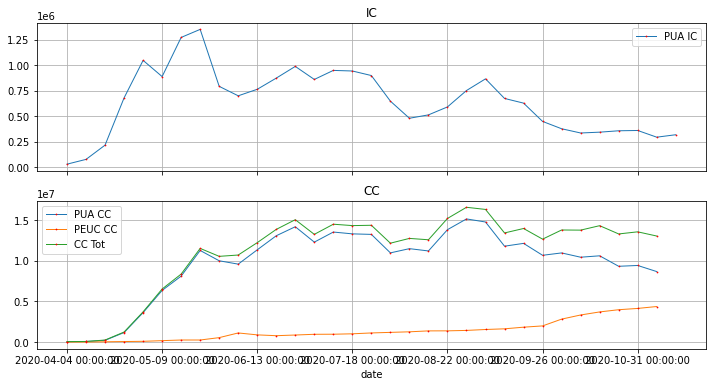

In [15]:
figwd = 12
fight= 6
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[figwd, fight], sharex=True)
for i, key in enumerate(dfs.keys()):
    print(f"Plotting {key}")
    ax = axs[i]
    dfs[key].plot(ax=ax, x="date",  kind='line', linestyle='-', marker='o', lw=1, title=key,
               mec='red', mfc='black', ms=0.75, legend=True, label=None, grid=True)

The *regular* IC values have been about 750K so this new program is about half that.
The *regular* CC values have been about 7.5 million so this new data is about the same.
Later I might combine the regular and special data, but for now it's enough just to have the special data.